In [2]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la

from src.structured_random_features.src.models.weights import V1_weights

# Packages for fft and fitting data
from scipy import fftpack as fft
from sklearn.linear_model import Lasso

# Package for importing image representation
from PIL import Image, ImageOps

from src.V1_Compress import generate_Y, compress
import pandas as pd
import itertools
import dask
from dask.distributed import Client, progress
import seaborn as sns
import time
import os.path

In [3]:
def opt_hyperparams(data): 
    # Try to use pd group_by to group repetition and get avg
    
    # Among those average, get the lowest error hyperparam
    ordered_data = pd.DataFrame(data).sort_values(by = 'error', ascending = True)
    print(ordered_data.head(5))
    
    return ordered_data.head(1)

In [4]:
def run_sim(rep, alp, num, sz, freq, img_arr):
    num = int(num)
    img_arr = np.array([img_arr]).squeeze()
    dim = img_arr.shape
    n, m = dim

    # Generate V1 weight with y
    W = V1_weights(num, dim, sz, freq) 
    y = generate_Y(W, img_arr)
    W_model = W.reshape(num, n, m)
    
    # Call function and calculate error
    theta, reform, s = compress(W_model, y, alp)
    error = np.linalg.norm(img - reform, 'fro') / np.sqrt(m*n)
    
    return error, theta, reform, s

In [5]:
img_nm_list = ['tree_part1.jpg', 'city_part2.png', 'city_part3.png']
for img_nm in img_nm_list:
    image_path ='image/{img}'.format(img = img_nm)

    #DF version after looking at Desk method

    # Set up hyperparameters that would affect results
    delay_list = []
    params = []
    alpha = np.logspace(-3, 3, 7)
    rep = np.arange(10)
    num_cell = [100, 200, 500]
    cell_sz = [2, 5, 7]
    sparse_freq = [1, 2, 5]

    # Load Image
    #     image_path = 'image/city_part2.png'
    image_nm = image_path.split('/')[1].split('.')[0]
    img = Image.open(image_path)
    img = ImageOps.grayscale(img)
    img_arr = np.asarray(img)

    save_path = os.path.join("result/{img_nm}/V1".format(img_nm = image_nm))



    search_list = [rep, alpha, num_cell, cell_sz, sparse_freq]

    # All combinations of hyperparameter to try
    search = list(itertools.product(*search_list))             
    search_df = pd.DataFrame(search, columns= [ 'rep', 'alp', 'num_cell', 'cell_sz', 'sparse_freq'])
    print(search_df.head())

    # Call dask
    client = Client()

    # counter = 0; # Keep track of number of iteration. Debugging method
    for p in search_df.values:
        delay = dask.delayed(run_sim)(*p, img_arr)
        delay_list.append(delay)

    print('running dask completed')

    futures = dask.persist(*delay_list)
    print('futures completed')
    progress(futures)
    print('progressing futures')

    # Compute the result
    results = dask.compute(*futures)
    print('result computed')
    results_df = pd.DataFrame(results, columns=['error', 'theta', 'reform', 's'])

    # Add error onto parameter
    params_result_df = search_df.join(results_df['error'])

    # save parameter_error data with error_results data
    params_result_df.to_csv(os.path.join(save_path, "param_" + "_".join(str.split(time.ctime().replace(":", "_"))) + ".csv"))
    results_df.to_csv(os.path.join(save_path, "result_" + "_".join(str.split(time.ctime().replace(":", "_"))) + ".csv"))




   rep    alp  num_cell  cell_sz  sparse_freq
0    0  0.001       100        2            1
1    0  0.001       100        2            2
2    0  0.001       100        2            5
3    0  0.001       100        5            1
4    0  0.001       100        5            2
running dask completed
futures completed
progressing futures
result computed
   rep    alp  num_cell  cell_sz  sparse_freq
0    0  0.001       100        2            1
1    0  0.001       100        2            2
2    0  0.001       100        2            5
3    0  0.001       100        5            1
4    0  0.001       100        5            2


/home/bans/anaconda3/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34477 instead
  warnings.warn(


running dask completed
futures completed
progressing futures
result computed
   rep    alp  num_cell  cell_sz  sparse_freq
0    0  0.001       100        2            1
1    0  0.001       100        2            2
2    0  0.001       100        2            5
3    0  0.001       100        5            1
4    0  0.001       100        5            2


/home/bans/anaconda3/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43429 instead
  warnings.warn(


running dask completed
futures completed
progressing futures
result computed


In [6]:
results_df = pd.DataFrame(results, columns=['error', 'theta', 'reform', 's'])
results_df

,error,theta,reform,s
0,128.595358,"[[2.0753792757293947, -2.939713260140235, 2.99...","[[101.22724157695097, -20.46598564255528, 146....","[4291.290365832666, -101.3671894941771, -296.9..."
1,829.265900,"[[-1.3411462405184829, 0.9890292721018017, 0.7...","[[710.038142907944, -1210.7814874812275, 1409....","[4283.545888777847, -78.21203888522433, -33.98..."
2,2204.136279,"[[2.218461417764338, -0.9833211379938638, -2.6...","[[-1557.6850159359365, 1723.902888854448, 2321...","[4157.758836116884, -316.2260883985498, -104.1..."
3,112.721442,"[[1.973176422359584, -0.2929156043668017, 0.29...","[[70.56960068182491, 286.89310456103556, -100....","[4280.809640535858, -226.96787671362222, -192...."
4,1498.514718,"[[-3.599878382938171, 3.1788990520129117, 0.37...","[[-21.628116685291815, 481.1109855582867, -406...","[4174.11199580884, -406.3544064908659, -55.938..."
...,...,...,...,...
1885,74.424631,"[[-2.268370746031691, 1.8648789002302468, 0.31...","[[69.2122191768816, 69.26885804925021, 69.8230...","[4029.3155431908162, -263.88155388248725, -212..."
1886,77.425139,"[[7.858212388468309, 2.325375680181166, -8.369...","[[36.320443528848756, 38.04410051096007, 41.51...","[4064.6328908239407, -336.7213601240507, -250...."
1887,62.163469,"[[3.5022449139475924, 1.7723777699716643, -2.0...","[[126.0837220412615, 125.05908313450841, 123.1...","[4045.0873907732152, -77.21671273352334, -0.0,..."
1888,74.762793,"[[-2.9959818473684585, 0.6162951981356461, 3.4...","[[68.26480469809766, 67.20321578215582, 65.700...","[4010.6046804116663, -276.62147602641403, -198..."


In [7]:
temp = search_df.join(results_df['error'])
opt_hyperparams(temp)

      rep     alp  num_cell  cell_sz  sparse_freq      error
354     1  1000.0       100        5            1  59.078480
1308    6  1000.0       200        5            1  59.460446
1296    6  1000.0       100        2            1  60.230080
1110    5  1000.0       100        5            1  61.249132
1113    5  1000.0       100        7            1  61.954105


,rep,alp,num_cell,cell_sz,sparse_freq,error
354,1,1000.0,100,5,1,59.07848


In [8]:
image_path = 'image/tree_part1.jpg'

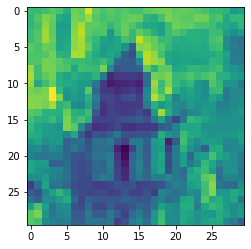

In [13]:
alpha = np.logspace(-3, 3, 7)

image_path = 'image/city_part2.png'
image_nm = image_path.split('/')[1].split('.')[0]
img = Image.open(image_path)
img = ImageOps.grayscale(img)
img_arr = np.asarray(img)

plt.imshow(img_arr)

